<a href="https://colab.research.google.com/github/eraldoribeiro/Homography-Python-Nonlinear-Optimization/blob/main/mappingImagesUsingHomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2 as cv
from  matplotlib import pyplot as plt
from scipy.optimize import fsolve, root

import io
import PIL
import requests

%matplotlib inline

In [2]:
# Model corners (features detected on the model)
modelCorners = np.float32([[0,0],[1000,0],[1000,1000],[0,1000]])
modelCorners = modelCorners.T;
print("Model points =\n", modelCorners)

Model points =
 [[   0. 1000. 1000.    0.]
 [   0.    0. 1000. 1000.]]


In [3]:
image_response = requests.get('https://raw.githubusercontent.com/eraldoribeiro/Homography-Python-Nonlinear-Optimization/main/stone.png')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

(1106, 1135, 3)


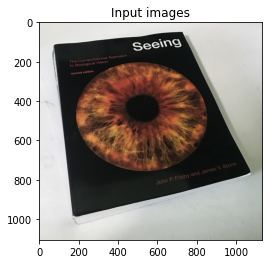

In [4]:
print(im.shape)
plt.imshow(im)
plt.title('Input images')
plt.show()

In [5]:
# Image features (corners)
imageCorners = np.float32([[80,112],[734,46],[1082,766],[176,990]])
imageCorners = imageCorners.T;
print("Image corners =\n", imageCorners)

Image corners =
 [[  80.  734. 1082.  176.]
 [ 112.   46.  766.  990.]]


Text(0.5, 1.0, 'Corner points')

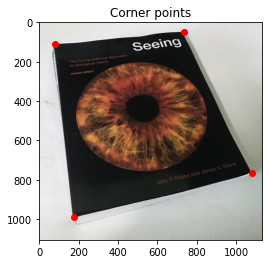

In [6]:
# Display corners on image
fig, ax = plt.subplots()
ax.imshow(im)
ax.plot(imageCorners[0,:], imageCorners[1,:], 'ro', linewidth=10)
plt.title('Corner points')

Transformation matrix = 
 [[ 1.42885683e+00 -1.56230359e-01 -9.68107459e+01]
 [ 1.77685507e-01  1.76070185e+00 -2.11413447e+02]
 [-1.12112704e-04  5.88571580e-04  1.00000000e+00]]


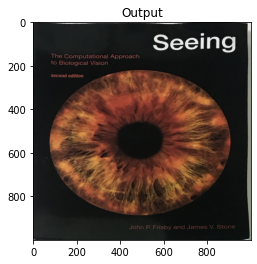

In [7]:
# Using the OpenCV functions 
# Function cv.getPerspectiveTransform expects row vectors, not column vectors
M = cv.getPerspectiveTransform(imageCorners.T,modelCorners.T)
print("Transformation matrix = \n", M)
dstImage = cv.warpPerspective(im,M,(1000,1000))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

In [8]:
# Model coordinates 
u = modelCorners[0,:]
v = modelCorners[1,:]

In [9]:
# Image coordinates
x = imageCorners[0,:]
y = imageCorners[1,:]

In [10]:
# Build the system matrix to solve for the homography
I = 4   # Number of features 
j = 0;
A = np.zeros( (2*I, 9) )
for i in range(0,I):
    A[j    ,:]  = [    0,         0,     0,    -u[i],   -v[i],     -1,    y[i]*u[i],      y[i]*v[i],    y[i] ]
    A[j+1  ,:]  = [  u[i],     v[i],     1,        0,       0,     0,   -x[i]*u[i],     -x[i]*v[i],   -x[i] ]
    j = j + 2 
    
    
np.set_printoptions(formatter={'float': '{: 0.2f}'.format},suppress=True)    
print("A = \n", A)   

A = 
 [[ 0.00  0.00  0.00 -0.00 -0.00 -1.00  0.00  0.00  112.00]
 [ 0.00  0.00  1.00  0.00  0.00  0.00 -0.00 -0.00 -80.00]
 [ 0.00  0.00  0.00 -1000.00 -0.00 -1.00  46000.00  0.00  46.00]
 [ 1000.00  0.00  1.00  0.00  0.00  0.00 -734000.00 -0.00 -734.00]
 [ 0.00  0.00  0.00 -1000.00 -1000.00 -1.00  766000.00  766000.00  766.00]
 [ 1000.00  1000.00  1.00  0.00  0.00  0.00 -1082000.00 -1082000.00
  -1082.00]
 [ 0.00  0.00  0.00 -0.00 -1000.00 -1.00  0.00  990000.00  990.00]
 [ 0.00  1000.00  1.00  0.00  0.00  0.00 -0.00 -176000.00 -176.00]]


In [11]:
# SVD of A
U,D,Vt = np.linalg.svd(A)
print("Vt = \n", Vt)

Vt = 
 [[ 0.00  0.00  0.00  0.00  0.00  0.00 -0.66 -0.75 -0.00]
 [-0.00  0.00 -0.00 -0.00  0.00  0.00  0.75 -0.66 -0.00]
 [-0.31 -0.50 -0.00  0.67  0.45  0.00 -0.00  0.00 -0.00]
 [-0.23  0.70  0.00  0.58 -0.24  0.00  0.00 -0.00  0.26]
 [ 0.53  0.26  0.00  0.30  0.20  0.00  0.00  0.00 -0.72]
 [ 0.43 -0.43 -0.00  0.35 -0.70  0.00  0.00 -0.00  0.12]
 [-0.62 -0.09  0.01 -0.04 -0.46  0.01 -0.00  0.00 -0.63]
 [ 0.00  0.00 -0.81 -0.00  0.00  0.58 -0.00  0.00  0.00]
 [ 0.01  0.00  0.58 -0.00  0.00  0.81  0.00 -0.00  0.01]]


In [12]:
# Solution is the last column of V
Phi_hat = Vt.T[:,-1]

# Re-shape into matrix form 
Phi =  np.float32(
        [[ Phi_hat[0],   Phi_hat[1],    Phi_hat[2] ],
        [ Phi_hat[3],   Phi_hat[4],    Phi_hat[5] ],
        [ Phi_hat[6],   Phi_hat[7],    Phi_hat[8] ]]
       )

print("Phi = \n", Phi)

Phi = 
 [[ 0.01  0.00  0.58]
 [-0.00  0.00  0.81]
 [ 0.00 -0.00  0.01]]


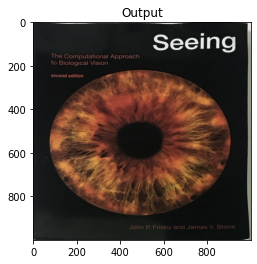

In [13]:
dstImage = cv.warpPerspective(im,np.linalg.inv(Phi),(1000,1000))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

In [14]:
print(x.shape[0])

4


In [15]:
def objectiveFunction (phi, x, y, u, v):

    I = x.shape[0]
    
    sum_squares = 0.0

    for i in range(0,I):
        # Denominator is common to both x and y produced by model.
        d = phi[6] * u[i] + phi[7] * v[i] + phi[8]

        # Numerator of x from model
        n1 = phi[0] * u[i] + phi[1] * v[i] + phi[2]
        x_model = n1 / d

        # Numerator of y from model
        n2 = phi[3] * u[i] + phi[4] * v[i] + phi[5]
        y_model = n2 / d

    #    print(x_model,x[i])
    #    print(y_model,y[i])

        # Squared norm
        squared_norm = ( x[i] - x_model )**2 +  ( y[i] - y_model )**2        

        # Sum of squared norms
        sum_squares = sum_squares + squared_norm

    return sum_squares 

In [16]:
Phi_guess = Phi
Phi_guess

array([[ 0.01,  0.00,  0.58],
       [-0.00,  0.00,  0.81],
       [ 0.00, -0.00,  0.01]], dtype=float32)

In [17]:
import scipy

out = scipy.optimize.minimize(objectiveFunction,x0=Phi_guess, args=(x, y, u, v),options={'disp': True})

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 302
         Gradient evaluations: 29


In [18]:
print(out.x)


[ 0.01  0.00  0.58 -0.00  0.00  0.81  0.00 -0.00  0.01]


In [19]:
Phi_refined = np.reshape(out.x, (3,3))
Phi_refined

array([[ 0.01,  0.00,  0.58],
       [-0.00,  0.00,  0.81],
       [ 0.00, -0.00,  0.01]], dtype=float32)

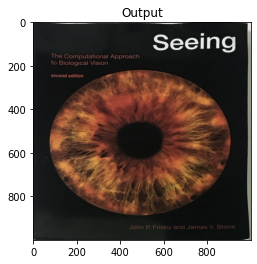

In [20]:
dstImage = cv.warpPerspective(im,np.linalg.inv(Phi_refined),(1000,1000))
plt.imshow(dstImage),
plt.title('Output')
plt.show()